In [1]:
!pip3 install torch
!pip3 install torchvision
!pip3 install pytorch-model-summary

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import os
import pytorch_model_summary
from torch.utils.data import Dataset, DataLoader
import torchvision as tv
import torch.nn.functional as F
from datetime import datetime
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt

In [3]:
if 'google.colab' in str(get_ipython()):
    print('Running on Colab')
    from google.colab import drive

    drive.mount('/content/gdrive')
    data_dir = Path('/content/gdrive/My Drive', 'dataset', 'fault diagnosis')
    checkpoint_dir = Path('/content/gdrive/My Drive', 'checkpoints', 'fam')
else:
    data_dir = Path('.', 'dataset')
    checkpoint_dir = Path('.', 'checkpoints', 'fam')

data_dir.mkdir(exist_ok=True, parents=True)
checkpoint_dir.mkdir(exist_ok=True, parents=True)

file_name = {}
files = os.listdir(data_dir)
for file in files:
    if file.find('Train') != -1:
        file_name['Train'] = file
    elif file.find('Test') != -1:
        file_name['Test'] = file

Running on Colab
Mounted at /content/gdrive


In [42]:
def conv_block(inp, oup, kernel, stride, padding, bias, num):
    layer_norm = nn.LayerNorm(2048)
    for name, param in layer_norm.named_parameters():
      if name == 'bias':
          param.requires_grad = False

    seq = nn.Sequential()
    seq.add_module(f'Conv_{num}', nn.Conv1d(inp, oup, kernel, stride, 'same', bias=bias))
    seq.add_module(f'LayerNorm_{num}',layer_norm)
    seq.add_module(f'Tanh_{num}', nn.Tanh())
    return seq

# Call this function after optimizer step, add constraint on weight norm
def max_norm_(model, min_val=0.8, max_val=1.2, eps=1e-8):
    for name, param in model.named_parameters():
        if 'bias' not in name and 'Conv' in name:
            with torch.no_grad():
                norm = param.norm('fro', dim=[3, 1], keepdim=True)**2
                desired = torch.clamp(norm, min=min_val, max=max_val)
                param.copy_(param * torch.sqrt(desired / (eps + norm)))

def global_power_pooling(x):
    return torch.pow(x, 2).mean(3).mean(2)

# Network for FAM
class ConvolutionFAM(nn.Module):
    def __init__(self, in_channel, kernel_size, bias, stride, channels, n_class=12):
        super(ConvolutionFAM, self).__init__()
        block = conv_block
        self.features = []
        for idx, out_channel in enumerate(channels):
            self.features.append(block(in_channel, out_channel, kernel_size, stride[idx], 'same', bias, idx))
            in_channel = out_channel
        self.features = nn.Sequential(*self.features)
        self.classifier = nn.Linear(channels[-1], n_class)

    def forward(self, x):
        x_freq = self.features(x)
        x_out = global_power_pooling(x_freq)
        x_out = self.classifier(x_out)
        return x_freq, x_out

class BearingDataset(Dataset):
    def __init__(self, file_path, window_size):
        self.dataset = pd.read_csv(file_path, header=None).reset_index(drop=True)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset.iloc[idx, 0:window_size]
        y = self.dataset.iloc[idx, window_size]
        return torch.reshape(torch.FloatTensor(x.to_numpy()), (1, 1, window_size)), torch.tensor(y)

def training(model, dataloader, optimizer):
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    dataset_len = len(dataloader.dataset)
    model.train()

    for batch in tqdm(dataloader):
        x, y = batch
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()
        
        optimizer.zero_grad()
        _, pred = model(x)
        softmax_pred = F.softmax(pred, dim=1)
        loss = F.cross_entropy(pred, y)

        epoch_loss += loss.detach()
        epoch_accuracy += torch.sum(torch.argmax(softmax_pred, dim=1) == y, dtype=torch.int64).detach()

        loss.backward()
        optimizer.step()
        max_norm_(model)
    
    epoch_loss /= dataset_len
    epoch_accuracy = epoch_accuracy / dataset_len * 100

    return epoch_loss, epoch_accuracy

# calculate FAM
def freq_activation_map(model, input, width, channels, target_label):
    '''
        Param:
            model : Neural Network Object
            input : timeseries data
            width : length of power_spectrum(input)
            channels : # last channel of the model
    '''
    fam = torch.zeros(input.shape[0], 1, width)
    if torch.cuda.is_available():
        fam = fam.cuda()    

    with torch.no_grad():
        freq, labels = model(torch.reshape(input, (-1, 1, 1, input.shape[-1])))
        labels = torch.argmax(F.softmax(labels, dim=1), dim=1)
        labels = torch.where(labels == target_label, 1., 0.)
        labels = torch.unsqueeze(torch.reshape(labels, [-1, 1]).repeat(1, width), 1)
        for c in range(channels):
            sp = freq[:, c, :, :]
            if torch.cuda.is_available():
                sp = sp.cuda()
            
            sp = power_spectrum(sp)
            sp = sp * labels            

            if model.classifier.weight[target_label, c] > 0:
                fam += model.classifier.weight[target_label, c] * sp
      
    return torch.squeeze(torch.sum(fam, dim=0)), torch.sum(labels[:, 0, 0], dim=0)

def normalize_freq(fam):
    max_fam, _ = torch.max(fam, dim=-1, keepdim=True)
    return torch.div(fam, max_fam)

# This is from P. Welch's method to compute power spectrum, check [3]
def power_spectrum(t_freq):
    result = torch.abs(torch.fft.rfft(t_freq))**2
    return result / torch.mean(result, dim=2, keepdim=True)

In [43]:
lr = 1e-3
batch_size = 256
epochs = 100
sampling_rate = 12000
labels = ['Normal', 'FAULT7_INNER', 'FAULT14_INNER', 'FAULT21_INNER', 'FAULT28_INNER',
    'FAULT7_BALL', 'FAULT14_BALL', 'FAULT21_BALL', 'FAULT28_BALL',
    'FAULT7_OUTER', 'FAULT14_OUTER', 'FAULT21_OUTER']

window_size = 2048
n_class = 12
bias = False
kernel_size = (1, 7)
in_channel = 1
stride = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
channels = [4, 4, 8, 8, 16, 16, 16, 32, 32, 32]


model = ConvolutionFAM(in_channel, kernel_size, bias, stride, channels, n_class)

if torch.cuda.is_available():
    model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [45]:
train_data = BearingDataset(Path(data_dir, 'bearing_dataset.csv'), window_size)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)

In [46]:
# model.load_state_dict(torch.load(Path(checkpoint_dir, 'CNN_FAM_21_12_30')))

for epoch in trange(epochs):
    loss, accuracy = training(model, train_loader, optimizer)
    print(f'Epoch {epoch+1} :: loss : {loss:.8f} / accuracy : {accuracy:.8f}%')

torch.save(model.state_dict(), Path(checkpoint_dir, 'CNN_FAM_21_12_30'))

<All keys matched successfully>

In [47]:
dummy_input = torch.zeros(batch_size, in_channel, 1, window_size)
if torch.cuda.is_available():
    dummy_input = dummy_input.cuda()

print(pytorch_model_summary.summary(model, dummy_input))

--------------------------------------------------------------------------
      Layer (type)           Output Shape         Param #     Tr. Param #
          Conv1d-1      [256, 4, 1, 2048]              28              28
       LayerNorm-2      [256, 4, 1, 2048]           4,096           2,048
            Tanh-3      [256, 4, 1, 2048]               0               0
          Conv1d-4      [256, 4, 1, 2048]             112             112
       LayerNorm-5      [256, 4, 1, 2048]           4,096           2,048
            Tanh-6      [256, 4, 1, 2048]               0               0
          Conv1d-7      [256, 8, 1, 2048]             224             224
       LayerNorm-8      [256, 8, 1, 2048]           4,096           2,048
            Tanh-9      [256, 8, 1, 2048]               0               0
         Conv1d-10      [256, 8, 1, 2048]             448             448
      LayerNorm-11      [256, 8, 1, 2048]           4,096           2,048
           Tanh-12      [256, 8, 1, 2

In [48]:
freq_intervals = np.fft.rfftfreq(window_size, d=1/sampling_rate)
total_fam = torch.zeros(n_class, len(freq_intervals))
total_len = torch.zeros(n_class, 1)
if torch.cuda.is_available():
    total_fam = total_fam.cuda()
    total_len = total_len.cuda()

for batch in tqdm(train_loader):
    x, y = batch
    if torch.cuda.is_available():
        x = x.cuda()    
    for c in range(n_class):
        tmp_fam, cnt = freq_activation_map(model, x, len(freq_intervals), channels[-1], c)
        total_fam[c, :] += tmp_fam
        total_len[c] += cnt

total_fam /= total_len

  0%|          | 0/54 [00:00<?, ?it/s]

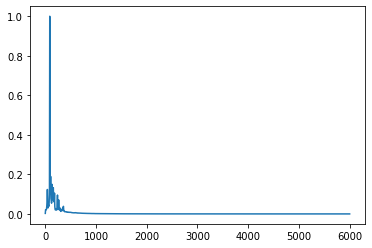

In [49]:
rtotal_fam = normalize_freq(total_fam).cpu().detach()
columns_ = freq_intervals
plt.plot(columns_, rtotal_fam[0, :])

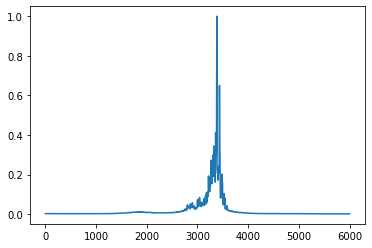

In [50]:
plt.plot(columns_, rtotal_fam[5, :])

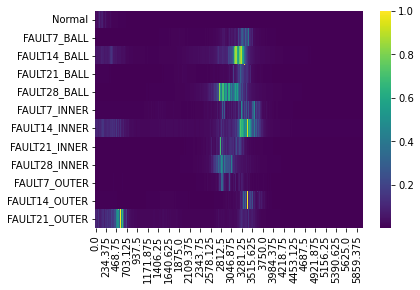

In [51]:
result = pd.DataFrame(rtotal_fam.numpy(),
                      index = ['Normal', 'FAULT7_INNER', 'FAULT14_INNER', 'FAULT21_INNER', 'FAULT28_INNER',
    'FAULT7_BALL', 'FAULT14_BALL', 'FAULT21_BALL', 'FAULT28_BALL',
    'FAULT7_OUTER', 'FAULT14_OUTER', 'FAULT21_OUTER'],
                      columns = columns_,
                      )

new_index = ['FAULT21_OUTER', 'FAULT14_OUTER', 'FAULT7_OUTER', 'FAULT28_INNER',
             'FAULT21_INNER', 'FAULT14_INNER', 'FAULT7_INNER', 'FAULT28_BALL', 
             'FAULT21_BALL', 'FAULT14_BALL', 'FAULT7_BALL', 'Normal']

new_index.reverse()

result = result.reindex(new_index)

sns.heatmap(result,
            cmap='viridis',
            )